Stainless Steel Data Set
http://www.worldstainless.org/statistics/foreign_trade_stainless_scrap

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

import os


In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [7]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [8]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [50]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)

rcParams['figure.figsize'] = 9, 6

#test_stationarity(LME_stationary.dropna())

LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df.index = df['ds']
df = df.iloc[:, 1:]


df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
2000-11-06,-166.60,-605.075,294.55,47.90,-171.65,-1016.80,347.45,-290.8375,-28.25,3.225,446.455,-235.225
2000-11-07,-23.10,-483.975,323.70,220.90,-3.90,-1132.90,336.05,-281.8375,-130.15,192.075,453.505,-193.650
2000-11-08,94.15,-683.575,206.55,233.50,87.75,-1196.15,379.80,324.9125,-155.00,946.425,552.255,-79.200
2000-11-09,100.40,-715.425,152.65,230.85,-21.85,-805.65,255.80,207.5125,-73.10,559.525,595.605,228.850
2000-11-10,57.90,-614.575,91.55,324.60,-105.35,-948.00,119.90,319.0125,-107.10,476.275,679.780,863.050


In [51]:


'''
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc[date_boundary:,:]
y_test = y[date_boundary:]

X_train = X.loc[:date_boundary, :]
y_train = y[:date_boundary]
'''

date_boundary = '2017-10-14'

exp1 = df.index.year == 2001
exp2 = df.index.year == 2002
exp3 = df.index.year == 2003
exp4 = df.index.year == 2004
exp5 = df.index.year == 2005
exp6 = df.index.year == 2006

df1 = df[np.logical_or(exp1, exp2)]
df2 = df[exp3]

frames = [df1, df2]
train = pd.concat(frames)
test = df[exp4]


X_train = train[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
X_test = test[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]

y_train = train['y']
y_test = test['y']


## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [11]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


In [52]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index


# y_pred = y_pred.reindex(X_test.index)

[-0.00112299  0.26417992  0.02937659 -0.59315684 -0.06782932 -0.09054041
  0.34888334 -0.08503165  0.28279573  0.22898525  0.0267786 ]


## Back to Scale before Performance Analysis

In [53]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

ds
2004-01-01    14877.0
2004-01-02    14877.0
2004-01-05    14201.0
2004-01-06    14423.0
2004-01-07    14550.0
dtype: float64
ds
2001-01-29    6040.0
2001-01-30    6090.0
2001-01-31    5958.0
2001-02-01    6054.0
2001-02-02    6116.0
dtype: float64


In [29]:
# Sanity check for unscaling! 

LME_shifted[LME_shifted.index=='2004-01-01']


#LME[LME.index=='2018-10-31']

Unnamed: 1
2004-01-01    14877.0
Freq: B, Name: Cash Price ($/MT), dtype: float64

In [181]:
# Sanity Check
LME_shifted[LME_shifted.index=='2000-12-04']


Unnamed: 1
2000-12-04    5360.0
Freq: B, Name: Cash Price ($/MT), dtype: float64

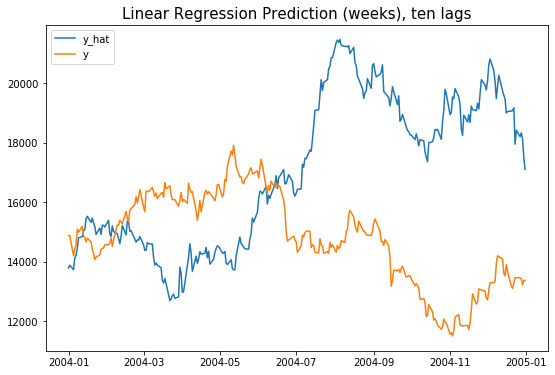

Mean Absolute Error: 3604.6704825934357
Mean Squared Error: 18445475.236254293
Root Mean Squared Error: 4294.819581339162


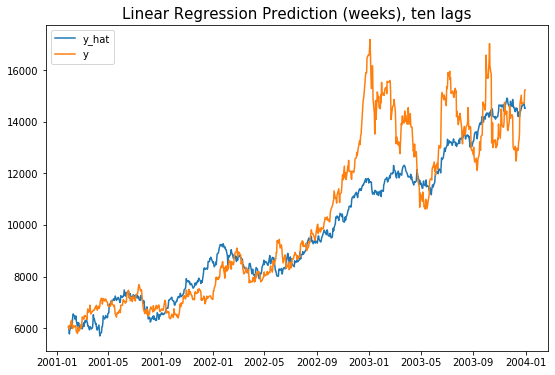

Mean Absolute Error: 902.0178626741182
Mean Squared Error: 1763721.444876001
Root Mean Squared Error: 1328.0517478155741


In [54]:
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows



K:  1
Mean Absolute Error: 1971.846306278373
Mean Squared Error: 5815334.970356256
Root Mean Squared Error: 2411.500564038138

K:  2
Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258

K:  3
Mean Absolute Error: 2017.7355301078792
Mean Squared Error: 6049001.952575765
Root Mean Squared Error: 2459.4718848923167

K:  4
Mean Absolute Error: 2103.286353541897
Mean Squared Error: 6685697.8615040295
Root Mean Squared Error: 2585.671646111321

K:  5
Mean Absolute Error: 2052.507215200683
Mean Squared Error: 6132598.357594826
Root Mean Squared Error: 2476.408358408368

K:  6
Mean Absolute Error: 2053.270834869709
Mean Squared Error: 6328580.765396506
Root Mean Squared Error: 2515.6670617147465

K:  7
Mean Absolute Error: 2071.357068371575
Mean Squared Error: 6389248.498800651
Root Mean Squared Error: 2527.6962829423655


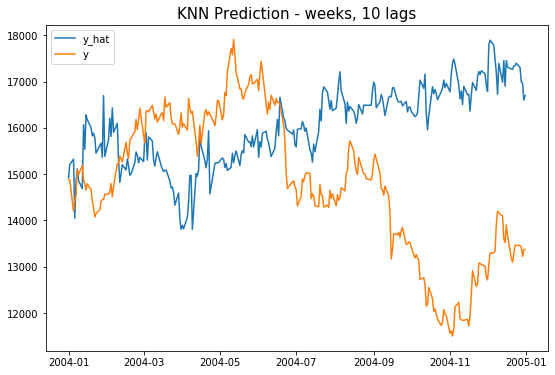

{'1': 1971.846306278373, '2': 1990.1314177168879, '3': 2017.7355301078792, '4': 2103.286353541897, '5': 2052.507215200683, '6': 2053.270834869709, '7': 2071.357068371575}


In [55]:
from sklearn import neighbors

cv_results = {}

for K in range(7):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

ds
2004-01-01    14877.0
2004-01-02    14877.0
2004-01-05    14201.0
2004-01-06    14423.0
2004-01-07    14550.0
dtype: float64
ds
2001-01-29    6040.0
2001-01-30    6090.0
2001-01-31    5958.0
2001-02-01    6054.0
2001-02-02    6116.0
dtype: float64


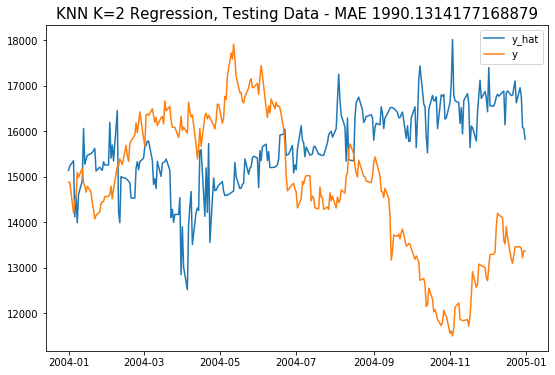

Mean Absolute Error: 1990.1314177168879
Mean Squared Error: 5720275.312136189
Root Mean Squared Error: 2391.709704821258


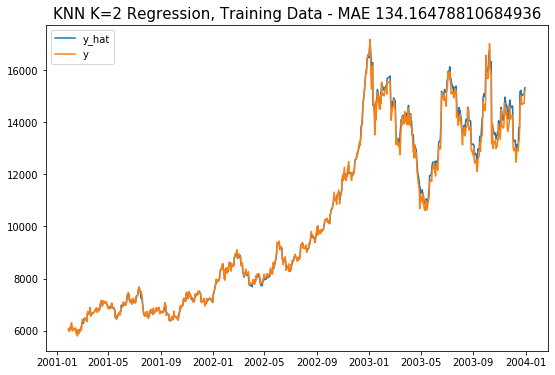

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [56]:
K = 2
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']
 


plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))



{'learning_rate': 0.0001, 'n_estimators': 50}
Mean Absolute Error: 2860.58147112579
Mean Squared Error: 13082665.576052396
Root Mean Squared Error: 3616.996761963217

{'learning_rate': 0.0001, 'n_estimators': 100}
Mean Absolute Error: 2994.669151259048
Mean Squared Error: 14386880.681054164
Root Mean Squared Error: 3793.0041762505566

{'learning_rate': 0.0001, 'n_estimators': 150}
Mean Absolute Error: 2966.5535228373183
Mean Squared Error: 14063768.600439781
Root Mean Squared Error: 3750.1691429107277

{'learning_rate': 0.0001, 'n_estimators': 200}
Mean Absolute Error: 2966.817454563528
Mean Squared Error: 14160243.316986373
Root Mean Squared Error: 3763.0098746862695

{'learning_rate': 0.0001, 'n_estimators': 250}
Mean Absolute Error: 2981.6895769733146
Mean Squared Error: 14347269.684195023
Root Mean Squared Error: 3787.7789909384924

{'learning_rate': 0.0001, 'n_estimators': 300}
Mean Absolute Error: 2941.686115686489
Mean Squared Error: 13881746.777272878
Root Mean Squared Error: 

Mean Absolute Error: 3255.732888307099
Mean Squared Error: 18121553.76783493
Root Mean Squared Error: 4256.941832799097

{'learning_rate': 0.3, 'n_estimators': 300}
Mean Absolute Error: 3297.410923300642
Mean Squared Error: 18600671.811399538
Root Mean Squared Error: 4312.8496161354315

{'learning_rate': 0.3, 'n_estimators': 350}
Mean Absolute Error: 3271.7936317472095
Mean Squared Error: 18298073.960367523
Root Mean Squared Error: 4277.62480359925

{'learning_rate': 0.3, 'n_estimators': 400}
Mean Absolute Error: 3266.230885049437
Mean Squared Error: 18202155.108719155
Root Mean Squared Error: 4266.398376701261

{'learning_rate': 0.3, 'n_estimators': 450}
Mean Absolute Error: 3291.0340477942664
Mean Squared Error: 18598863.35552997
Root Mean Squared Error: 4312.639951993439

Adaboost CV Results
{'learning_rate': 0.0001, 'n_estimators': 50} 2860.58147112579
{'learning_rate': 0.0001, 'n_estimators': 100} 2994.669151259048
{'learning_rate': 0.0001, 'n_estimators': 150} 2966.5535228373183


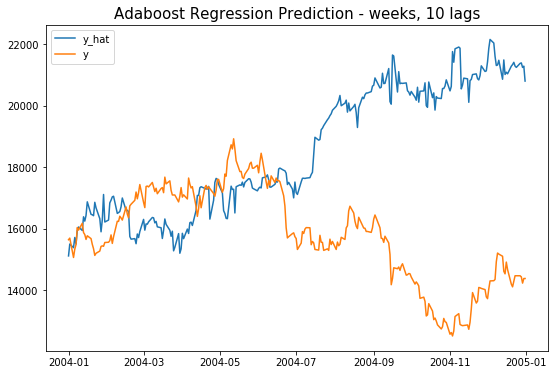

In [57]:
from sklearn.ensemble import AdaBoostRegressor

params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450],
                            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]})

cv_results = {}

for params in params1:

    regressor = AdaBoostRegressor(**params, random_state=1)


    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Adaboost CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()
    
    
    

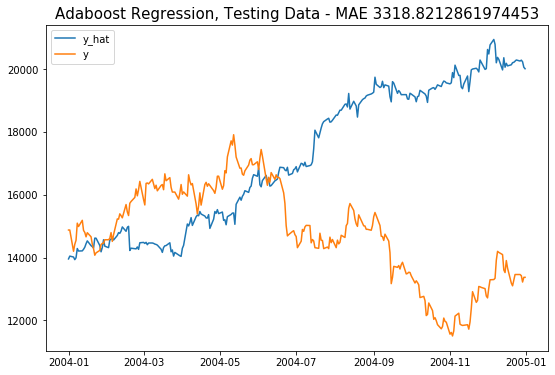

Mean Absolute Error: 3318.8212861974453
Mean Squared Error: 17958999.236988574
Root Mean Squared Error: 4237.805946122188


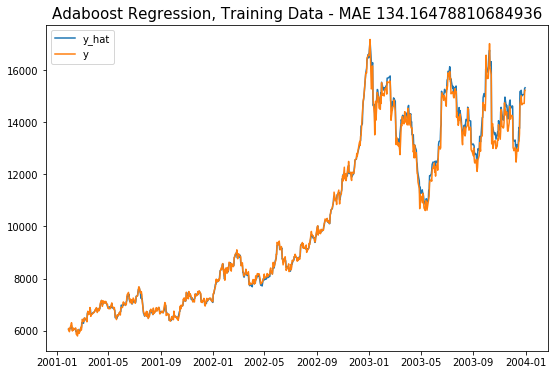

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [58]:
regressor = AdaBoostRegressor(learning_rate=0.1, n_estimators=50, random_state=1)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


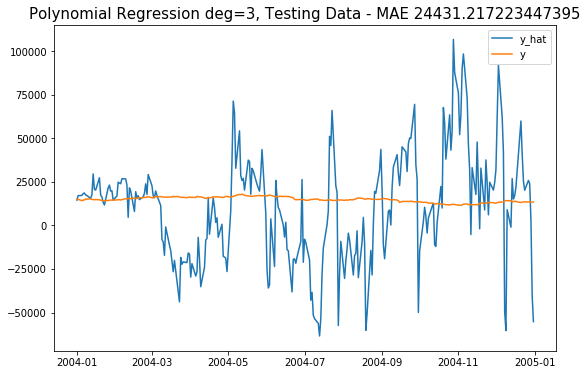

Mean Absolute Error: 24431.217223447395
Mean Squared Error: 1015987090.2631657
Root Mean Squared Error: 31874.552393142178


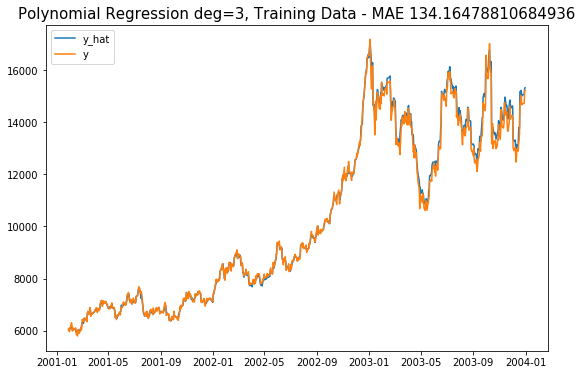

Mean Absolute Error: 134.16478810684936
Mean Squared Error: 40390.25152609091
Root Mean Squared Error: 200.97326072413443


In [60]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

y_pred = y_poly_pred


X_poly_train = polynomial_features.fit_transform(X_train)
y_poly_pred = regressor.predict(X_poly_train)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_train.index

y_pred_train_unscaled = y_poly_pred


##############

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))






{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

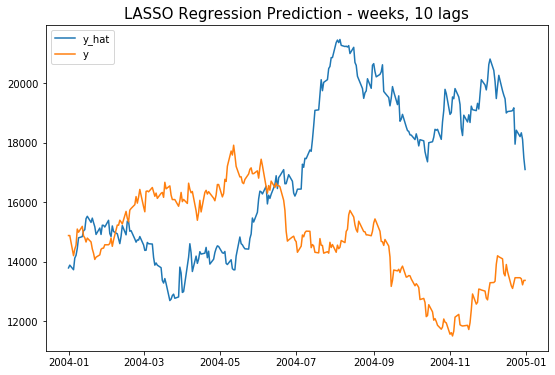

In [61]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'alpha': 1e-05}
Mean Absolute Error: 3604.6704820935724
Mean Squared Error: 18445475.230753116
Root Mean Squared Error: 4294.819580698719

{'alpha': 0.0001}
Mean Absolute Error: 3604.6704775591547
Mean Squared Error: 18445475.180746377
Root Mean Squared Error: 4294.819574876968

{'alpha': 0.001}
Mean Absolute Error: 3604.670431939005
Mean Squared Error: 18445474.67722607
Root Mean Squared Error: 4294.819516257473

{'alpha': 0.01}
Mean Absolute Error: 3604.6699760552374
Mean Squared Error: 18445469.64178186
Root Mean Squared Error: 4294.818930034404

{'alpha': 0.1}
Mean Absolute Error: 3604.6654239069308
Mean Squared Error: 18445419.36750844
Root Mean Squared Error: 4294.813077132512

{'alpha': 1}
Mean Absolute Error: 3604.6198541310973
Mean Squared Error: 18444915.763689008
Root Mean Squared Error: 4294.75444742642

Ridge CV Results
{'alpha': 1e-05} 3604.6704820935724
{'alpha': 0.0001} 3604.6704775591547
{'alpha': 0.001} 3604.670431939005
{'alpha': 0.01} 3604.6699760552374
{'alpha': 

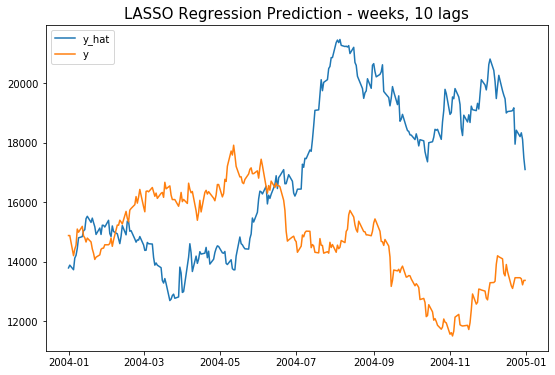

In [62]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()

In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
